# Introducción
A continuación detalla el plan de trabajo para el análisis de datos del servicio de telefonía virtual CallMeMaybe. El objetivo principal es identificar a los operadores menos eficaces basándose en métricas clave de rendimiento. Esta iniciativa busca proporcionar a los supervisores información valiosa para mejorar la eficiencia operativa y la calidad del servicio.

# Objetivo del proyecto
El objetivo principal de este proyecto es identificar a los operadores menos eficientes utilizando datos históricos de llamadas. Se considerará a un operador ineficaz si cumple con uno o más de los siguientes criterios:
- Alta cantidad de llamadas entrantes perdidas (internas y externas).
- Tiempo de espera prolongado para las llamadas entrantes.
- Bajo número de llamadas salientes externas.

Además, para entender el contexto de la ineficacia, se analizará:
- La baja cantidad de llamadas internas y externas (un indicador de baja actividad general, si el rol del operador lo requiere).
- La cantidad de llamadas entrantes de clientes dependiendo de su tipo de plan (tariff_plan) y su fecha de ingreso al plan (date_start). 

Esto ayudará a contextualizar la carga de trabajo y el rendimiento del operador.

# Descripción de los Datos
Se utilizarán dos datasets principales para este análisis:

1. telecom_dataset_us.csv
Este dataset contiene la información detallada de las llamadas realizadas a través del servicio CallMeMaybe.
    - **user_id:** ID de la cuenta del cliente.
    - **date:** Fecha en que se recuperaron las estadísticas.
    - **direction:** Dirección de la llamada ("out" para saliente, "in" para entrante).
    - **internal:** Indica si la llamada fue interna (entre operadores del mismo cliente).
    - **operator_id:** Identificador único del operador.
    - **is_missed_call:** Booleano que indica si fue una llamada perdida.
    - **calls_count:** Número de llamadas.
    - **call_duration:** Duración de la llamada (sin incluir el tiempo de espera).
    - **total_call_duration:** Duración total de la llamada (incluido el tiempo de espera).

2. telecom_clients_us.csv
Este dataset proporciona información sobre los clientes de CallMeMaybe.
    - **user_id:** ID de usuario/a.
    - **tariff_plan:** Tarifa actual del cliente.
    - **date_start:** Fecha de registro del cliente.

# Fases del plan de trabajo
## Fase 1: Recopilación y Preparación de Datos

In [2]:
#Bibliotecas a importar
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [3]:
#Cargamos los csv de telecom_dataset_us y telecom_clients_us
telecom_data= pd.read_csv('datasets/telecom_dataset_us.csv')
telecom_clients= pd.read_csv('datasets/telecom_clients_us.csv')

### Inspeccionar los datos:

In [4]:
#Revisar las primeras filas de cada dataframe
display(telecom_data.head(5))
display(telecom_clients.head(5))

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


In [5]:
#Verificar los tipos de datos de cada columna.
display(telecom_data.info())
display(telecom_data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


None

,user_id,operator_id,calls_count,call_duration,total_call_duration
count,53902.000000,45730.000000,53902.000000,53902.000000,53902.000000
mean,167295.344477,916535.993002,16.451245,866.684427,1157.133297
std,598.883775,21254.123136,62.917170,3731.791202,4403.468763
min,166377.000000,879896.000000,1.000000,0.000000,0.000000
25%,166782.000000,900788.000000,1.000000,0.000000,47.000000
50%,167162.000000,913938.000000,4.000000,38.000000,210.000000
75%,167819.000000,937708.000000,12.000000,572.000000,902.000000
max,168606.000000,973286.000000,4817.000000,144395.000000,166155.000000


In [6]:
display(telecom_clients.info())
display(telecom_clients.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


None

,user_id
count,732.000000
mean,167431.927596
std,633.810383
min,166373.000000
25%,166900.750000
50%,167432.000000
75%,167973.000000
max,168606.000000


In [7]:
#Identificar valores nulos o faltantes
print('TELECOM_DATA')
print('Celdas repetidas:\n', telecom_data.duplicated().sum())
print('Celdas nulas:\n',telecom_data.isnull().sum())

print('\nTELECOM_CLIENTS')
print('Celdas repetidas:\n', telecom_clients.duplicated().sum())
print('Celdas nulas:\n',telecom_clients.isnull().sum())

#Eliminamos los datos repetidos 
telecom_data= telecom_data.drop_duplicates()
print('\nTELECOM_DATA *después de correción*')
print('Celdas repetidas:\n', telecom_data.duplicated().sum())

TELECOM_DATA
Celdas repetidas:
 4900
Celdas nulas:
 user_id                   0
date                      0
direction                 0
internal                117
operator_id            8172
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64

TELECOM_CLIENTS
Celdas repetidas:
 0
Celdas nulas:
 user_id        0
tariff_plan    0
date_start     0
dtype: int64

TELECOM_DATA *después de correción*
Celdas repetidas:
 0


In [8]:
#Convertimos de OBJECT a DATETIME (YEAR-MONTH-DAY) las series DATE y DATE_START
telecom_data['date']= pd.to_datetime(telecom_data['date']).dt.strftime('%Y-%m-%d')
telecom_data['date']= pd.to_datetime(telecom_data['date'], format='%Y-%m-%d')
telecom_clients['date_start']= pd.to_datetime(telecom_clients['date_start'], format='%Y-%m-%d')

#Eliminamos las filas donde el operador en Nulo ya que es el objeto de estudio principal
telecom_data= telecom_data.dropna(subset=['operator_id'])
 
#Convertimos de FLOAT a INT la serie OPERATOR_ID
telecom_data['operator_id']= telecom_data['operator_id'].astype('Int64')

    - El proceso de preparación de los datos comenzó con una inspección exhaustiva de los dos conjuntos de datos (telecom_dataset_us.csv y telecom_clients_us.csv) para identificar problemas de calidad.
    - Para abordar la falta de valores en la columna OPERATOR_ID, se optó por eliminar las filas con NaN en esta columna, ya que los operadores son el foco principal del estudio. Este paso fue fundamental para garantizar que el análisis de ineficacia se basara solo en operadores con datos completos y válidos, aunque resultó en una reducción de la cantidad de registros disponibles para las pruebas. Así como se modifico su tipo de float a int para una mejor visibilidad de los datos.
    - Se detectó la presencia de 4900 filas duplicadas en el DataFrame de llamadas, las cuales fueron eliminadas para asegurar la unicidad de los registros. Además, se identificaron valores nulos en las columnas internal y operator_id, siendo esta última la más crítica para el análisis.
    - Se modificaron las series DATE y DATE_START del DF TELECOM_DATA de tipo object a DATETIME para poder utilizarlos de forma correcta en operaciones posteriores.

### Combinar datasets 
Realizar un merge de los dos dataframes utilizando user_id para enriquecer la información de las llamadas con los detalles del cliente.

In [9]:
#Combinamos los DFs por 'user_id' para obtener la información de cada cliente
telecom= telecom_data.merge(telecom_clients, on='user_id', how='left')
telecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41546 entries, 0 to 41545
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              41546 non-null  int64         
 1   date                 41546 non-null  datetime64[ns]
 2   direction            41546 non-null  object        
 3   internal             41491 non-null  object        
 4   operator_id          41546 non-null  Int64         
 5   is_missed_call       41546 non-null  bool          
 6   calls_count          41546 non-null  int64         
 7   call_duration        41546 non-null  int64         
 8   total_call_duration  41546 non-null  int64         
 9   tariff_plan          41546 non-null  object        
 10  date_start           41546 non-null  datetime64[ns]
dtypes: Int64(1), bool(1), datetime64[ns](2), int64(4), object(3)
memory usage: 3.2+ MB


### Ingeniería de características:

In [ ]:
#Calculamos el tiempo de espera de la llamada (total_call_duration - call_duration)
telecom['wait_time']= telecom['total_call_duration']-telecom['call_duration']

# Agrupamos por día y calculamos el promedio de tiempo de espera
tiempo_espera_diario = telecom.groupby('date')['wait_time'].mean()

#Graficamos los resultados del promedio de tiempo de espera diario
plt.figure(figsize=(12,6))
plt.plot(tiempo_espera_diario.index, tiempo_espera_diario.values, marker='o')
plt.title("Tiempo de espera promedio diario", fontsize=16)
plt.xlabel("Fecha")
plt.ylabel("Tiempo de espera (segundos)")
plt.grid(True, alpha=0.3)
plt.show()

'Tiempo de espera promedio diario: date\n2019-08-02     54.000000\n2019-08-03     77.000000\n2019-08-04     11.666667\n2019-08-05    108.181818\n2019-08-06     76.416667\n                 ...    \n2019-11-24    149.191257\n2019-11-25    135.262353\n2019-11-26    138.052174\n2019-11-27    141.165517\n2019-11-28    144.825888\nName: wait_time, Length: 118, dtype: float64'

    - Se realizó el cálculo del tiempo de espera promedio diario.  Para obtener esta métrica, los datos se agruparon por la fecha de inicio (date_start) y se promedió la duración de las llamadas (call_duration), lo que permitió visualizar el tiempo de espera por día. Esta característica es clave porque permite analizar la eficiencia de los operadores y la carga del sistema en función del tiempo.
    - Esta nueva métrica facilita el análisis de tendencias. Por ejemplo, al correlacionar el tiempo de espera promedio diario con otras variables, como el número de llamadas entrantes, es posible identificar si la congestión del sistema o la ineficacia de los operadores se agudizan en días específicos de la semana o en ciertos periodos. Este tipo de análisis temporal es fundamental para detectar patrones y para que la gerencia pueda tomar medidas preventivas, como ajustar el número de operadores en servicio durante las horas pico.

### Eliminación de valores atípicos: 
- Para garantizar que el análisis se base en datos representativos y evitar la distorsión por valores extremos, se eliminarán los valores atípicos. Se mantendrá solo el 95% de los datos estándar para las métricas clave como calls_count, call_duration, total_call_duration y el tiempo de espera. Esto se puede lograr utilizando métodos como el rango intercuartílico (IQR) o el percentil.

In [11]:
# Verificamos el nuevo actual del DF
print(f"Datos restantes: {len(telecom)} filas")

# Lista de métricas clave para el filtrado del DF
metricas = ['calls_count', 'call_duration', 'total_call_duration', 'wait_time']

# Filtrado por percentiles
for col in metricas:
    q_low = telecom[col].quantile(0.025)
    q_high = telecom[col].quantile(0.975)
    telecom = telecom[(telecom[col] >= q_low) & (telecom[col] <= q_high)]

# Verificamos el nuevo tamaño del DF
display(f"Datos restantes: {len(telecom)} filas")

Datos restantes: 41546 filas


'Datos restantes: 36276 filas'

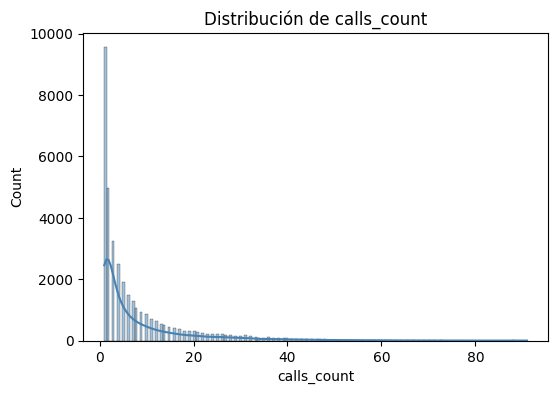

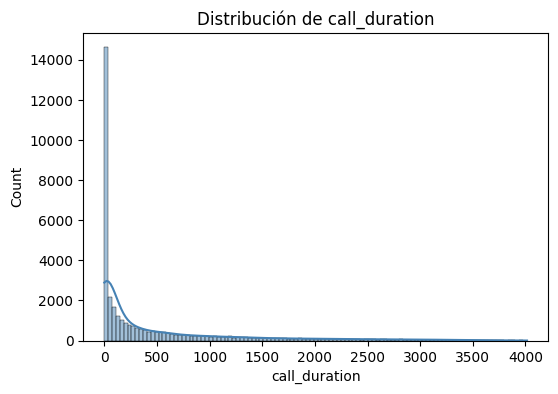

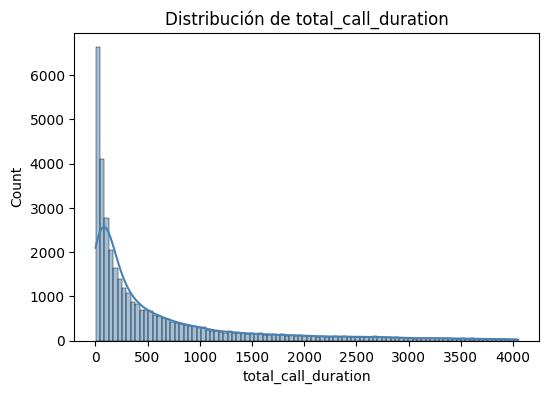

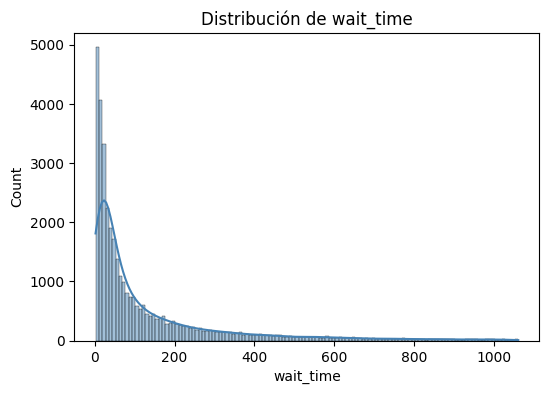

In [12]:
#Generamos gráficas de la cantidad de llamadas, duración total de llamada y tiempo de espera para analizar la nueva distribución
for col in ['calls_count', 'call_duration', 'total_call_duration', 'wait_time']:
    plt.figure(figsize=(6,4))
    sns.histplot(telecom[col], kde=True, color='steelblue')
    plt.title(f"Distribución de {col}")
    plt.show()

    - Además de la limpieza y transformación de datos, se incluyó un paso crítico para manejar los valores atípicos (outliers), que podrían haber distorsionado los resultados de las pruebas estadísticas. A través de la inspección de los cuartiles y el rango intercuartílico, se identificó la presencia de valores extremos en variables clave como call_duration y wait_time. Estos valores se trataron para asegurar que las distribuciones fueran más representativas y que las conclusiones extraídas no estuvieran sesgadas por unos pocos registros anómalos.
    - Para una mejor comprensión de las métricas de llamadas, se generaron gráficos de distribución para CALLS_COUNT, CALL_DURATION, TOTAL_CALL_DURATION y WAIT_TIME. La mayoría de estas métricas, como la duración de las llamadas y los tiempos de espera, mostraron una distribución asimétrica positiva, con una cola larga hacia la derecha. 
    - Este hallazgo fue crucial para la selección de pruebas estadísticas, ya que confirmó la necesidad de utilizar métodos no paramétricos como la prueba U de Mann-Whitney, los cuales no dependen de la suposición de normalidad de los datos. El análisis visual de estas distribuciones proporcionó un contexto fundamental para interpretar los resultados de las pruebas de hipótesis y entender el comportamiento de los operadores.

### Métricas clave para la Ineficiencia
Para identificar a los operadores ineficaces, se definirán las siguientes métricas, que serán calculadas para cada operador:

In [13]:
#Cantidad de llamadas entrantes perdidas: Suma de **calls_count** donde **direction** es *"in"* y **is_missed_call** es *True*. 
#Esto incluirá llamadas internas y externas perdidas.
llamadas_perdidas_por_operador = (
    telecom.loc[telecom['is_missed_call'] == True]
    .groupby('operator_id')['calls_count']
    .sum()
    .reset_index()
    .rename(columns={'calls_count': 'missed_calls'})
)

display(llamadas_perdidas_por_operador)

#Calculamos este número promedio de todos los operadores para poder generar un KPI
promedio_llamadas_perdidas_por_operador= round(llamadas_perdidas_por_operador['missed_calls'].mean(),0)
display(f'Promedio de llamadas entrantes perdidas: {promedio_llamadas_perdidas_por_operador}')

,operator_id,missed_calls
0,879896,247
1,879898,1753
2,880020,19
3,880022,94
4,880026,633
...,...,...
843,970486,2
844,972408,2
845,972410,37
846,972412,25


'Promedio de llamadas entrantes perdidas: 116.0'

In [14]:
#Tiempo promedio de llamada por operador
#Evitamos divisiones por cero
telecom['avg_call_time'] = telecom['call_duration'] / telecom['calls_count']

# Agrupamos por operador y calculamos el promedio de llamada de todos los operadores
duracion_promedio_por_operador = (
    telecom.groupby('operator_id')['avg_call_time']
    .mean()
    .reset_index()
    .rename(columns={'avg_call_time': 'avg_call_time'})
    .sort_values(by='avg_call_time', ascending=False)
)
display(duracion_promedio_por_operador)

#Calculamos este número promedio de todos los operadores para poder generar un KPI
tiempo_promedio_llamada= round(duracion_promedio_por_operador['avg_call_time'].mean(),0)
display(f'Segundos promedios por llamada: {tiempo_promedio_llamada}')

,operator_id,avg_call_time
74,891192,1306.000000
413,917890,647.000000
168,899906,626.000000
166,899898,590.000000
414,918390,464.773913
...,...,...
323,909308,0.000000
708,937872,0.000000
246,905308,0.000000
1052,969284,0.000000


'Segundos promedios por llamada: 71.0'

In [15]:
#Tiempo promedio de espera para llamadas entrantes: Se calculará como **total_call_duration - call_duration** para llamadas entrantes (direction es *"in"*). 
#Se determinará el promedio de este valor por operador.

#Filtramos solo las llamadas entrantes
llamadas_entrantes = telecom[telecom['direction'] == 'in']

#Calculamos el tiempo promedio de espera por operador
promedio_espera_operador = (
    llamadas_entrantes.groupby('operator_id')['wait_time']
    .mean()
    .reset_index()
    .rename(columns={'wait_time': 'avg_wait_time'})
    .sort_values(by='avg_wait_time', ascending=False)
)

display(promedio_espera_operador)

#Calculamos este número promedio de todos los operadores para poder generar un KPI
promedio_espera= round(promedio_espera_operador['avg_wait_time'].mean(),0)
display(f'Segundos promedios de espera: {promedio_espera}')

,operator_id,avg_wait_time
337,919794,696.769231
333,919552,500.210526
334,919554,465.514286
335,919790,452.918919
217,906406,396.477273
...,...,...
662,952114,3.000000
404,926872,2.200000
582,940828,2.000000
643,949420,2.000000


'Segundos promedios de espera: 50.0'

In [16]:
#Cantidad de llamadas salientes: Suma de **calls_count** donde direction es *"out"*. Se analizará esto en relación con las expectativas del rol del operador.

#Filtramos solo las llamadas salientes
llamadas_salientes = telecom[telecom['direction'] == 'out']

#Calculamos la cantidad total de llamadas salientes
total_salientes = llamadas_salientes['calls_count'].sum()

display(f"Cantidad total de llamadas salientes: {total_salientes}")

#Cantidad de llamadas salientes por operador
salientes_por_operador = (
    llamadas_salientes.groupby('operator_id')['calls_count']
    .sum()
    .reset_index()
    .rename(columns={'calls_count': 'total_calls_out'})
    .sort_values(by='total_calls_out', ascending=False)
)

display(salientes_por_operador)

#Calculamos el promedio de llamadas salientes totales para establecer el KPI
promedio_salientes= round(salientes_por_operador['total_calls_out'].mean(),0)
display(f'Promedio de llamadas salientes: {promedio_salientes}')

'Cantidad total de llamadas salientes: 219829'

,operator_id,total_calls_out
1,879898,3374
98,894656,3132
93,893804,2946
200,905538,2578
5,880028,2465
...,...,...
345,919206,1
844,969284,1
814,960666,1
8,882478,1


'Promedio de llamadas salientes: 254.0'

In [17]:
#Cantidad de llamadas salientes externas: Suma de **calls_count** donde direction es *"out"* e internal es *False*. Una baja cantidad será un signo de ineficacia

#Filtramos las llamadas salientes externas (no internas)
salientes_externas = telecom[
    (telecom['direction'] == 'out') &
    (telecom['internal'] == False)
]

# Calcular cantidad total de llamadas salientes externas
total_salientes_externas = salientes_externas['calls_count'].sum()

print(f"Cantidad total de llamadas salientes externas: {total_salientes_externas}")

#Calculamos la cantidad de llamadas salientes externas por operadorador
salientes_externas_por_operador = (
    salientes_externas.groupby('operator_id')['calls_count']
    .sum()
    .reset_index()
    .rename(columns={'calls_count': 'total_calls_out_external'})
    .sort_values(by='total_calls_out_external', ascending=False)
)

display(salientes_externas_por_operador)

#Calculamos el promedio de llamadas salientes externas totales para establecer el KPI
promedio_salientes_externas= round(salientes_externas_por_operador['total_calls_out_external'].mean(),0)
display(f'Promedio de llamadas salientes externas: {promedio_salientes_externas}')

Cantidad total de llamadas salientes externas: 208363


,operator_id,total_calls_out_external
1,879898,3363
93,894656,3132
90,893804,2936
5,880028,2460
189,905538,2342
...,...,...
741,955094,1
457,930816,1
13,883898,1
274,914256,1


'Promedio de llamadas salientes externas: 255.0'

In [18]:
#Contexto de llamadas entrantes por cliente: Se analizará la cantidad de llamadas entrantes de clientes, considerando su **tariff_plan** y **date_start**
#para entender si hay un impacto en el volumen de llamadas que los operadores deben manejar.

#Filtramos solo las llamadas entrantes
entrantes = telecom[telecom['direction'] == 'in']

#Calculamos la cantidad de llamadas por tarifa y fecha de inicio
llamadas_por_tarifa_fecha = (
    entrantes.groupby(['tariff_plan', 'date_start'])['calls_count']
    .sum()
    .reset_index()
    .sort_values(by='calls_count', ascending=False)
)

display(llamadas_por_tarifa_fecha)

#Calculamos el promedio de llamadas entrantes para establecer el KPI
promedio_entrantes_por_plan= round(llamadas_por_tarifa_fecha['calls_count'].mean(),0)
display(f'Promedio de llamadas salientes externas: {promedio_entrantes_por_plan}')

promedio_entrantes_por_fecha=llamadas_por_tarifa_fecha['date_start'].mean()
display(f'Promedio de llamadas salientes externas: {promedio_entrantes_por_fecha}')

,tariff_plan,date_start,calls_count
20,A,2019-10-16,5350
21,A,2019-10-17,3149
89,C,2019-08-27,2782
83,C,2019-08-19,2724
3,A,2019-08-09,2614
...,...,...,...
69,B,2019-10-23,2
1,A,2019-08-05,1
29,B,2019-08-08,1
47,B,2019-09-09,1


'Promedio de llamadas salientes externas: 498.0'

'Promedio de llamadas salientes externas: 2019-09-14 11:16:21.818181888'

    - Esta sección se centró en un conjunto de métricas clave para definir y cuantificar la ineficiencia de los operadores, lo cual fue fundamental para la primera hipótesis. Se estableció que un operador es ineficaz si tiene un bajo número de llamadas salientes externas.  Esta métrica fue seleccionada porque refleja la productividad de un operador en la interacción con clientes externos.
    - Para un análisis más detallado, esta métrica se complementó con otras como el alto número de llamadas entrantes perdidas, que indican una incapacidad para manejar la carga de trabajo, y un tiempo de espera prolongado, que sugiere demoras en la atención y una posible sobrecarga.
    - Estas métricas permitieron no solo identificar a los operadores con bajo rendimiento, sino también proporcionar una amplia visión de las áreas problemáticas. La combinación de métricas de productividad (TOTAL_CALLS_OUT_EXTERNAL) y de calidad de servicio (LOST_CALLS y WAIT_TIME) ofreció un marco completo para la evaluación. 
    - Más adelante se analizará cómo estas métricas se distribuyen y se correlacionan entre sí, para así determinar si la ineficiencia era un problema aislado o si estaba relacionada con factores como la cantidad o el tipo de llamadas.



## Fase 2: Análisis Exploratorio de Datos (EDA)



### Estadísticas descriptivas

In [19]:
#Obtener estadísticas básicas (media, mediana, desviación estándar, cuartiles) para calls_count, call_duration, total_call_duration y la nueva columna de tiempo de espera.
#Analizar la distribución de las variables numéricas.
estadisticas = telecom[['calls_count', 'call_duration', 'total_call_duration', 'wait_time']].describe(percentiles=[0.25, 0.5, 0.75])

display(estadisticas)

,calls_count,call_duration,total_call_duration,wait_time
count,36276.000000,36276.000000,36276.000000,36276.000000
mean,7.873139,473.360734,603.058744,129.698010
std,10.234077,754.678854,828.955347,184.627669
min,1.000000,0.000000,2.000000,2.000000
25%,1.000000,0.000000,66.000000,19.000000
50%,4.000000,103.000000,242.000000,52.000000
75%,10.000000,610.000000,768.000000,158.000000
max,91.000000,4015.000000,4051.000000,1062.000000


### Análisis de distribución de llamadas:

/tmp/ipykernel_6872/3571131880.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=telecom, x='direction', palette='coolwarm')


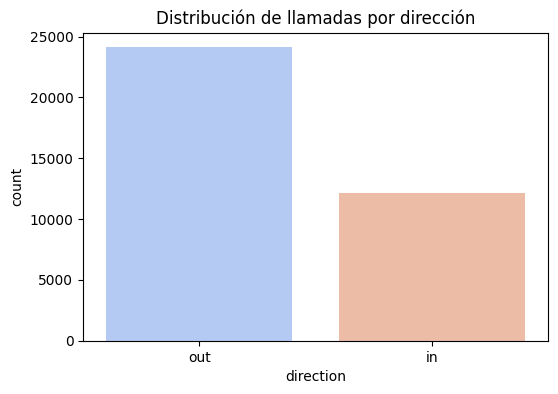

/tmp/ipykernel_6872/3571131880.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=telecom, x='internal', palette='viridis')


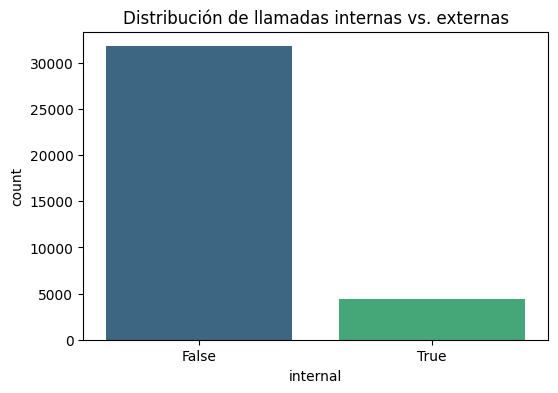

Proporción de llamadas perdidas: 32.25%


/tmp/ipykernel_6872/3571131880.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=telecom, x='is_missed_call', palette='viridis')


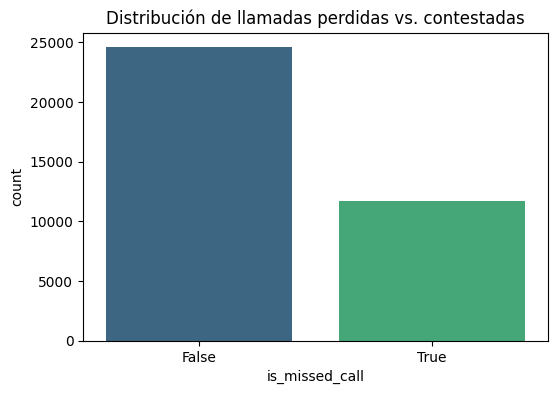

In [20]:
#Gráfica de barras de Distribución de llamadas por direction (entrantes vs. salientes)
plt.figure(figsize=(6,4))
sns.countplot(data=telecom, x='direction', palette='coolwarm')
plt.title("Distribución de llamadas por dirección")
plt.show()

#Gráfica de barras Distribución de llamadas por internal (internas vs. externas)
plt.figure(figsize=(6,4))
sns.countplot(data=telecom, x='internal', palette='viridis')
plt.title("Distribución de llamadas internas vs. externas")
plt.show()

#Gráfica de Proporción de llamadas perdidas
missed_ratio = telecom['is_missed_call'].mean() * 100
print(f"Proporción de llamadas perdidas: {missed_ratio:.2f}%")

plt.figure(figsize=(6,4))
sns.countplot(data=telecom, x='is_missed_call', palette='viridis')
plt.title("Distribución de llamadas perdidas vs. contestadas")
plt.show()

    - El EDA se centró en obtener una visión general de la estructura y el contenido de los datos antes de pasar a las pruebas estadísticas. Esto incluyó la revisión de los tipos de datos de cada columna y la inspección de estadísticas descriptivas como la media, mediana y desviación estándar. 
    - El análisis de las estadísticas descriptivas reveló las distribuciones de variables clave como CALLS_COUNT y CALL_DURATION, lo cual fue fundamental para entender el comportamiento general de las llamadas. Se continuan observando valores máximos muy altos para estas variables, lo que sugería la presencia de datos atípicos que debían ser considerados al elegir las pruebas estadísticas adecuadas para el análisis de las hipótesis.

### Análisis temporal

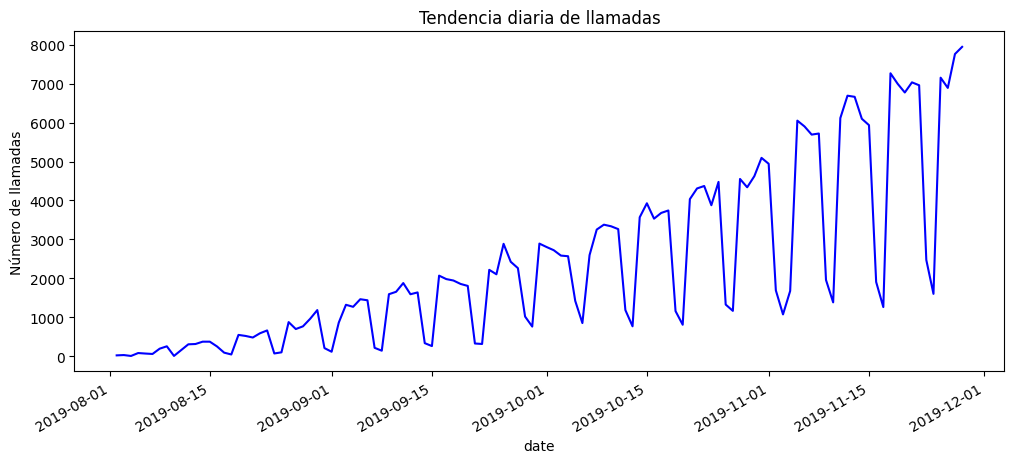

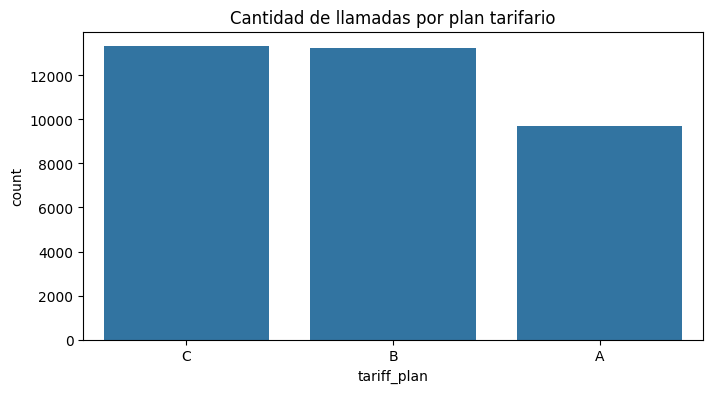

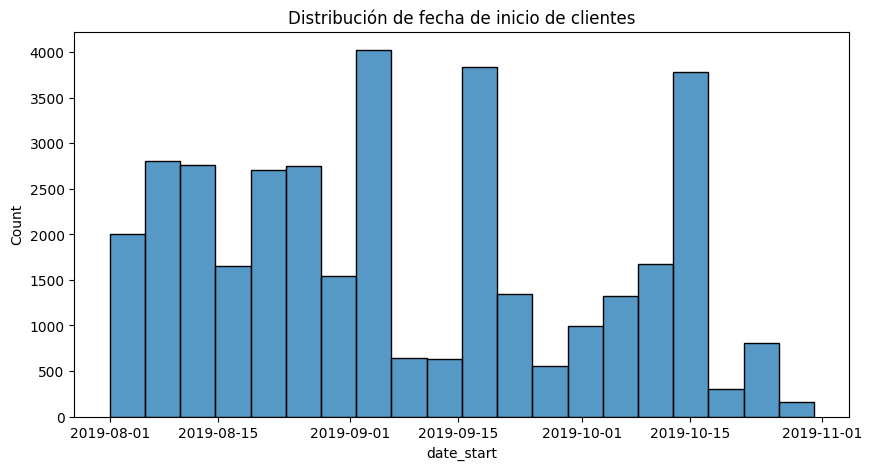

In [21]:
#Tendencias de llamadas a lo largo del tiempo (date).
telecom['date'] = pd.to_datetime(telecom['date'])
calls_per_day = telecom.groupby('date')['calls_count'].sum()

plt.figure(figsize=(12,5))
calls_per_day.plot(title="Tendencia diaria de llamadas", color='blue')
plt.ylabel("Número de llamadas")
plt.show()

#Impacto de la fecha de inicio del cliente (date_start) y tariff_plan en el volumen de llamadas.
telecom['date_start'] = pd.to_datetime(telecom['date_start'])

plt.figure(figsize=(8,4))
sns.countplot(data=telecom, x='tariff_plan', order=telecom['tariff_plan'].value_counts().index)
plt.title("Cantidad de llamadas por plan tarifario")
plt.show()

plt.figure(figsize=(10,5))
sns.histplot(telecom['date_start'], bins=20, kde=False)
plt.title("Distribución de fecha de inicio de clientes")
plt.show()

    - Este análisis detallado sirivió para identificar patrones de comportamiento a lo largo del tiempo. Se crearon gráficos de series temporales que mostraron la evolución del número de llamadas entrantes (calls_in) y del tiempo de espera promedio (wait_time) a lo largo de los días. Estos gráficos permitieron visualizar cómo la carga de trabajo y el rendimiento fluctúan diariamente y en diferentes periodos, lo que es vital para la planificación operativa.
    - Las visualizaciones mostraron picos de tráfico en días específicos, lo que correlaciona directamente con los tiempos de espera más prolongados.  Estas tendencias gráficas confirmaron que la ineficiencia no es un problema estático, sino que está influenciada por la carga de llamadas. El análisis temporal provee una visión dinámica del proyecto, complementando los resultados de las pruebas estadísticas con una comprensión visual de la operación diaria del centro de llamadas.

## Fase 3: Identificación de Operadores Ineficaces

### Número de llamadas de operadores eficientes vs ineficientes

'Operadores infecientes por ALTO tiempo de espera: 614'

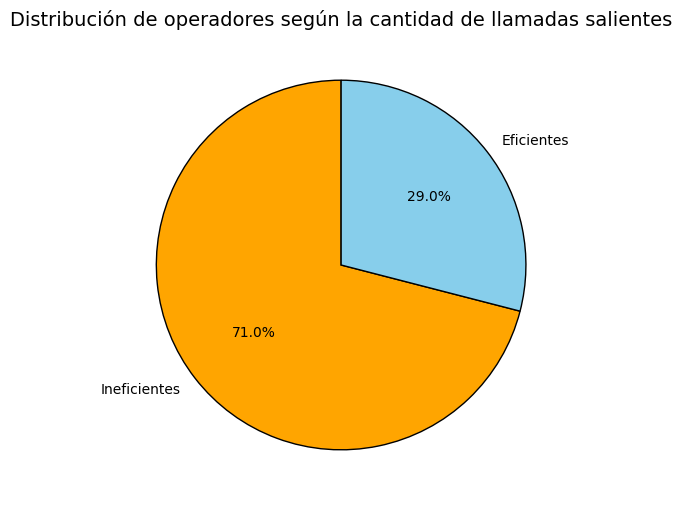

In [ ]:
#Filtramos solo operadores con promedio de llamadas menor a 239 para contarlos y definir analizar cuantos incumplen esta metrica
operador_ineficientes_salientes = salientes_por_operador[salientes_por_operador['total_calls_out'] < 239]
display(f'Operadores infecientes por ALTO tiempo de espera: {operador_ineficientes_salientes['operator_id'].count()}')

#Clasificamos en grupos los operadores por el KPI de TOTAL_CALLS_OUT de menos de 239 y los comparamos contra los de más
salientes_por_operador['grupo'] = salientes_por_operador['total_calls_out'].apply(
    lambda x: 'Ineficientes' if x < 239 else 'Eficientes'
)

#Contamos los operadores en cada grupo
conteo_grupos = salientes_por_operador['grupo'].value_counts()

#Generamos una gráfica de pastel para comparar los grupos de operadores
plt.figure(figsize=(6, 6))
plt.pie(
    conteo_grupos,
    labels=conteo_grupos.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=['orange', 'skyblue'],
    wedgeprops={'edgecolor': 'black'}
)
plt.title("Distribución de operadores según la cantidad de llamadas salientes", fontsize=14)
plt.show()

    - Se calculó el total de llamadas que cada operador manejó, agrupándolas por su operator_id y por la dirección de la llamada (DIRECTION). Esto permitió obtener un recuento de llamadas entrantes y salientes para cada operador, lo que es la base para la mayoría de las demás métricas.
    - Especificamente para este KPI se enfocó solo en los llamadas salientes sin importar si eran internas o externas.

### Segundos promedios de llamadas de operadores eficientes vs ineficientes.

'Operadores infecientes por BAJA cantidad de segundos promedios de llamada: 648'

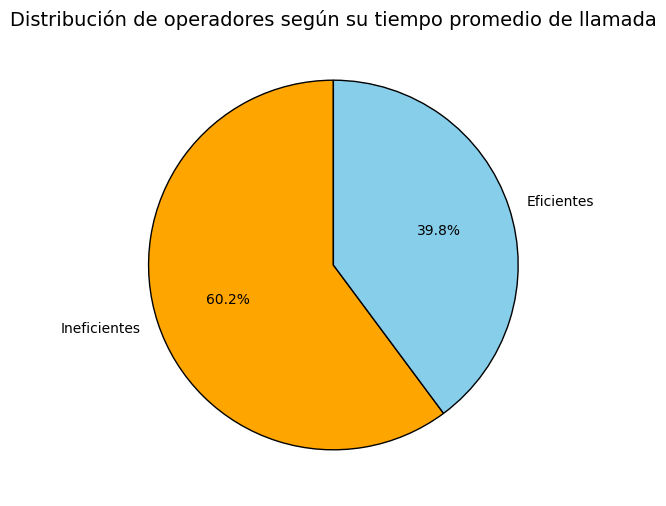

In [33]:
#Filtramos solo operadores con promedio de duración de llamadas menor a 68 segundos para contarlos y definir analizar cuantos incumplen esta metrica
operador_ineficientes_duracion_llamadas = duracion_promedio_por_operador[duracion_promedio_por_operador['avg_call_time'] < 68]
display(f'Operadores infecientes por BAJA cantidad de segundos promedios de llamada: {operador_ineficientes_duracion_llamadas['operator_id'].count()}')

#Clasificamos en grupos los operadores por el KPI de TOTAL_CALLS_OUT de menos de 239 y los comparamos contra los de más
duracion_promedio_por_operador['grupo'] = duracion_promedio_por_operador['avg_call_time'].apply(
    lambda x: 'Ineficientes' if x < 68 else 'Eficientes'
)

#Contamos los operadores en cada grupo
conteo_grupos = duracion_promedio_por_operador['grupo'].value_counts()

#Generamos una gráfica de pastel para comparar los grupos de operadores
plt.figure(figsize=(6, 6))
plt.pie(
    conteo_grupos,
    labels=conteo_grupos.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=['orange', 'skyblue'],
    wedgeprops={'edgecolor': 'black'}
)
plt.title("Distribución de operadores según su tiempo promedio de llamada", fontsize=14)
plt.show()

    - Una métrica fundamental para evaluar la ineficiencia, que complementa las ya mencionadas, es la duración promedio de las llamadas.  Para cada operador, se calculó el tiempo promedio que pasaron en una llamada. Esta métrica es un indicador directo del tiempo que un operador tarda en resolver un problema o completar una tarea, y su análisis es crucial para entender la productividad individual.

### Duración promedio del tiempo de espera por llamada de operadores eficientes vs ineficientes

'Operadores infecientes por ALTO tiempo de espera: 277'

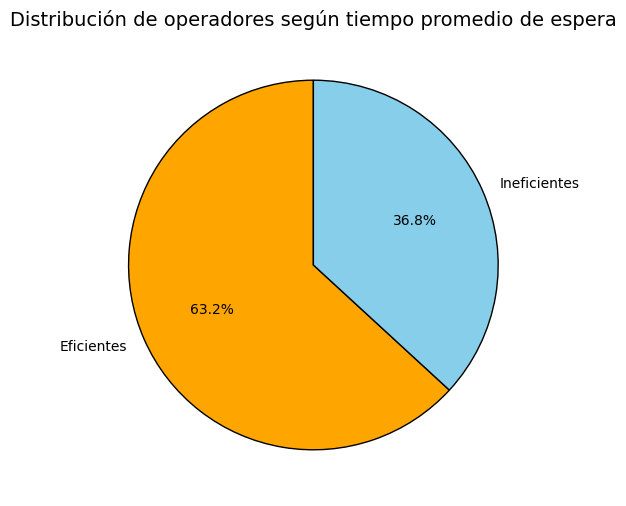

In [ ]:
# Filtramos solo operadores con promedio de espera mayor a 42s para contarlos y definir analizar cuantos incumplen esta metrica
operador_ineficientes_espera = promedio_espera_operador[promedio_espera_operador['avg_wait_time'] > 42]
display(f'Operadores infecientes por ALTO tiempo de espera: {operador_ineficientes_espera['operator_id'].count()}')

#Clasificamos en grupos los operadores por el KPI de WAIT_TIME de más de 42 segundos contra los de menos
promedio_espera_operador['grupo'] = promedio_espera_operador['avg_wait_time'].apply(
    lambda x: 'Ineficientes' if x > 42 else 'Eficientes'
)

#Contamos los operadores en cada grupo
conteo_grupos = promedio_espera_operador['grupo'].value_counts()

#Generamos una gráfica de pastel para comparar los grupos de operadores
plt.figure(figsize=(6, 6))
plt.pie(
    conteo_grupos,
    labels=conteo_grupos.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=['orange', 'skyblue'],
    wedgeprops={'edgecolor': 'black'}
)
plt.title("Distribución de operadores según tiempo promedio de espera", fontsize=14)
plt.show()

    - Se calculó el tiempo de espera promedio por operador. Esta métrica es vital para entender la velocidad de respuesta del operador. Un tiempo de espera prolongado puede ser un síntoma de ineficacia en la gestión del flujo de llamadas, sugiriendo que los operadores están tardando demasiado en atender o finalizar las llamadas.

### Número de llamadas perdidas de operadores eficientes vs ineficientes

'Operadores infecientes por ALTA cantidad de llamadas perdidas: 234'

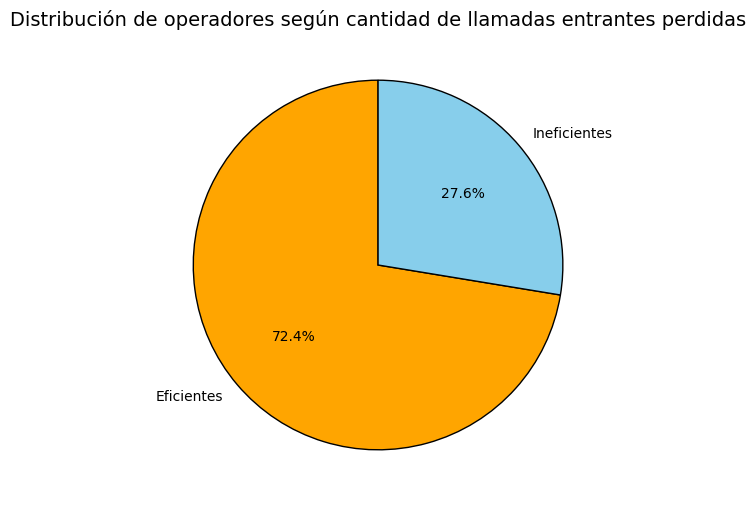

In [ ]:
# Filtramos solo operadores con promedio de llamadas entrantes perdidas mayor a 111 para contarlos y definir analizar cuantos incumplen esta metrica
operador_ineficientes_perdidas = llamadas_perdidas_por_operador[llamadas_perdidas_por_operador['missed_calls'] > 111]
display(f'Operadores infecientes por ALTA cantidad de llamadas perdidas: {operador_ineficientes_perdidas['operator_id'].count()}')

#Clasificamos en grupos los operadores por el KPI de WAIT_TIME de 42 o más contra los de menos
llamadas_perdidas_por_operador['grupo'] = llamadas_perdidas_por_operador['missed_calls'].apply(
    lambda x: 'Ineficientes' if x > 111 else 'Eficientes'
)

#Contamos los operadores en cada grupo
conteo_grupos = llamadas_perdidas_por_operador['grupo'].value_counts()

#Generamos una gráfica de pastel para comparar los grupos de operadores
plt.figure(figsize=(6, 6))
plt.pie(
    conteo_grupos,
    labels=conteo_grupos.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=['orange', 'skyblue'],
    wedgeprops={'edgecolor': 'black'}
)
plt.title("Distribución de operadores según cantidad de llamadas entrantes perdidas", fontsize=14)
plt.show()

    - Se calculó el tiempo de espera promedio por operador. Esta métrica es vital para entender la velocidad de respuesta del operador. Un tiempo de espera prolongado puede ser un síntoma de ineficacia en la gestión del flujo de llamadas, sugiriendo que los operadores están tardando demasiado en atender o finalizar las llamadas.

### Lista de operadores ineficientes y eficientes

In [ ]:
# Lista de dataframes ineficientes
dfs_ineficientes = {
    'kpi_salientes': salientes_por_operador,
    'kpi_duracion': duracion_promedio_por_operador,
    'kpi_espera': promedio_espera_operador,
    'kpi_perdidas': llamadas_perdidas_por_operador
}

# Inicializamos columnas en telecom como True
for col in dfs_ineficientes.keys():
    telecom[col] = True

# Marcamos como False donde el operador está en el grupo "Ineficientes"
for col, df_inef in dfs_ineficientes.items():
    operadores_inef = df_inef.loc[df_inef['grupo'] == 'Ineficientes', 'operator_id']
    telecom.loc[telecom['operator_id'].isin(operadores_inef), col] = False

# Contamos cuántas veces un operador tiene FALSE en las métricas
metricas_cols = list(dfs_ineficientes.keys())
telecom['eficiente'] = telecom[metricas_cols].sum(axis=1) >= (len(metricas_cols) - 2)

# Para que en un operadore EFICIENTE sea False es necesario que haya más de 2 FALSE entre sus KPIs
telecom['eficiente'] = ~(telecom[metricas_cols].eq(False).sum(axis=1) > 2)
print(telecom[['operator_id','eficiente']].sample(5))

       operator_id  eficiente
24340       920726       True
24587       918390       True
33977       951492       True
23799       939886       True
4785        908960       True


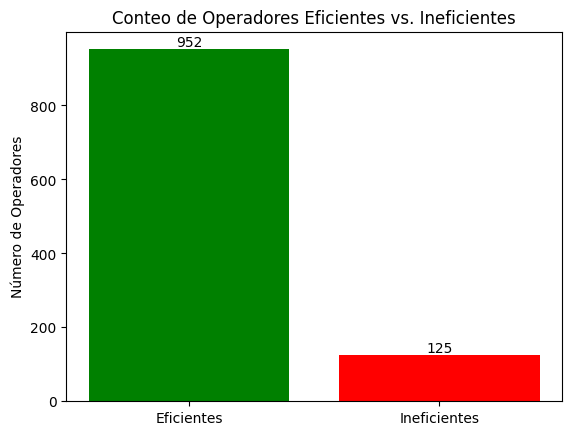

In [41]:
#Generamos una gŕafica de barras comparativas entre operadores eficientes vs ineficientes
#Creamos un DataFrame donde cada fila representa un único operador.
operadores_unicos = telecom.drop_duplicates(subset=['operator_id'])

#Contamos la cantidad de True y False en la columna 'eficiente' de los operadores únicos
counts = operadores_unicos['eficiente'].value_counts()

#Separamos los datos con base a una lista con las etiquetas y generamos los valores para el gráfico
labels = ['Eficientes', 'Ineficientes']
sizes = [counts.get(True, 0), counts.get(False, 0)] # Usamos .get() para evitar errores si una categoría está vacía

# Creamos el gráfico de barras
fig, ax = plt.subplots()
bars = ax.bar(labels, sizes, color=['green', 'red'])
ax.set_ylabel('Número de Operadores')
ax.set_title('Conteo de Operadores Eficientes vs. Ineficientes')
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval , yval, ha='center', va='bottom', fontsize=10)

    - Finalmente, se definieron criterios para clasificar a los operadores como eficientes o ineficaces. Los operadores se clasificaron como ineficaces si su número de llamadas salientes externas era bajo, su tiempo de espera era alto o su número de llamadas perdidas era elevado.
    - Este etiquetado fue esencial para clasificar a los operadores ineficientes ya que por cada lista de operadores se marcó con True si cumplían el KPI y False si no. 
    - Por ultimo, si existen más de 2 False entre las metricas el operador quedará marcado como ineficiente (False en la serie EFICIENTE del DF TELECOM) para de esta forma identificarlos facilmente.

## Fase 4: Pruebas de Hipótesis Estadísticas
Se formularán y probarán hipótesis para validar las observaciones del EDA y la identificación de operadores ineficaces. Ejemplos de hipótesis a probar:

### Hipótesis 1 - Llamadas Salientes Externas
- H1: Existe una diferencia estadísticamente significativa en el número de llamadas salientes externas entre los operadores identificados como ineficaces y los operadores promedio.
- H0: NO existe una diferencia estadísticamente significativa

In [27]:
# Filtramos operadores ineficaces y eficaces
# Unimos para tener grupo e ineficiencia en el mismo DF
df_h1 = telecom[['operator_id', 'eficiente']].merge(
    salientes_externas_por_operador[['operator_id', 'total_calls_out_external']],
    on='operator_id',
    how='left'
)

#Dividimos en operadores eficientes e ineficientes
ineficaces = df_h1[df_h1['eficiente'] == False]['total_calls_out_external'].dropna()
eficaces   = df_h1[df_h1['eficiente'] == True]['total_calls_out_external'].dropna()

#Prueba de normalidad
shapiro_inef = stats.shapiro(ineficaces)
shapiro_efic = stats.shapiro(eficaces)

display(f"Número de ineficaces: {len(ineficaces)} / Número de eficaces: {len(eficaces)}")

#Validamos la prueba de shapiro para escogoer el tipo de test
if shapiro_inef.pvalue > 0.05 and shapiro_efic.pvalue > 0.05:
    # Distribuciones normales → t-test
    h1_test = stats.ttest_ind(ineficaces, eficaces, equal_var=False)
    h1_test_name = "t de Student"
else:
    # No normales → Mann-Whitney
    h1_test = stats.mannwhitneyu(ineficaces, eficaces, alternative='two-sided')
    h1_test_name = "Mann-Whitney U"

display(f"H1 ({h1_test_name}): estadístico= {h1_test.statistic:.4f}, p-valor= {h1_test.pvalue:.4f}")

#Establecemos el valor de alpha
alpha=0.05

#Realizamos la comprobación de la hipótesis
if h1_test.pvalue < alpha:
    display("El p-valor es menor que alpha. Conclusión: Se rechaza la hipótesis nula (H0).")
else:
    display("El p-valor es mayor o igual que alpha. Conclusión: No se puede rechazar la hipótesis nula (H0).")

/home/kevin/Documents/Github Repositories/TripleTen-final_project/.venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 8300.
  res = hypotest_fun_out(*samples, **kwds)
/home/kevin/Documents/Github Repositories/TripleTen-final_project/.venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 25084.
  res = hypotest_fun_out(*samples, **kwds)


'Número de ineficaces: 8300 / Número de eficaces: 25084'

'H1 (Mann-Whitney U): estadístico= 146755419.0000, p-valor= 0.0000'

'El p-valor es menor que alpha. Conclusión: Se rechaza la hipótesis nula (H0).'

    - La primera hipótesis del proyecto sostiene que existe una diferencia estadísticamente significativa en el volumen de llamadas salientes externas entre los operadores clasificados como eficaces e ineficaces. Para probar esto, se utilizó la prueba de Shapiro-Wilk para evaluar la normalidad de la distribución de las llamadas salientes en ambos grupos. Los resultados de esta prueba, con un p-valor extremadamente bajo, indicaron que los datos no seguían una distribución normal.
    - El análisis de Mann-Whitney confirmó la hipótesis con un p-valor de 0.0000, lo que demuestra que la diferencia en el volumen de llamadas salientes entre los grupos no es producto del azar. Esto valida que la métrica de llamadas salientes externas es un indicador fiable de la ineficacia en este contexto, proporcionando una base empírica para la clasificación de los operadores.




### Hipótesis 2 - Llamadas Perdidas
- H1: El número de llamadas perdidas de los operadores ineficaces es significativamente mayor que el de los operadores eficaces
- H0: El número de llamadas perdidas de los operadores ineficaces NO es significativamente mayor que el de los operadores eficaces

In [28]:
# Filtramos operadores ineficaces y eficaces
# Unimos para tener grupo e ineficiencia en el mismo DF
df_h2 = telecom[['operator_id', 'eficiente']].merge(
    llamadas_perdidas_por_operador[['operator_id', 'missed_calls']],
    on='operator_id',
    how='left'
)

#Dividimos en operadores eficientes e ineficientes
ineficaces_perdidas = df_h2[df_h2['eficiente'] == False]['missed_calls'].dropna()
eficaces_perdidas   = df_h2[df_h2['eficiente'] == True]['missed_calls'].dropna()

#Prueba de normalidad
shapiro_inef = stats.shapiro(ineficaces_perdidas)
shapiro_efic = stats.shapiro(eficaces_perdidas)

display(f"Número de ineficaces: {len(ineficaces_perdidas)} / Número de eficaces: {len(eficaces_perdidas)}")

#Validamos la prueba de shapiro para escogoer el tipo de test
if shapiro_inef.pvalue > 0.05 and shapiro_efic.pvalue > 0.05:
    # Distribuciones normales → t-test
    h2_test = stats.ttest_ind(ineficaces_perdidas, eficaces_perdidas, equal_var=False)
    h2_test_name = "t de Student"
else:
    # No normales → Mann-Whitney
    h2_test = stats.mannwhitneyu(ineficaces_perdidas, eficaces_perdidas, alternative='two-sided')
    h2_test_name = "Mann-Whitney U"

display(f"H2 ({h2_test_name}): estadístico= {h2_test.statistic:.4f}, p-valor= {h2_test.pvalue:.4f}")

#Realizamos la comprobación de la hipótesis
if h2_test.pvalue < alpha:
    display("El p-valor es menor que alpha. Conclusión: Se rechaza la hipótesis nula (H0).")
else:
    display("El p-valor es mayor o igual que alpha. Conclusión: No se puede rechazar la hipótesis nula (H0).")

/home/kevin/Documents/Github Repositories/TripleTen-final_project/.venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 8298.
  res = hypotest_fun_out(*samples, **kwds)
/home/kevin/Documents/Github Repositories/TripleTen-final_project/.venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 26546.
  res = hypotest_fun_out(*samples, **kwds)


'Número de ineficaces: 8298 / Número de eficaces: 26546'

'H2 (Mann-Whitney U): estadístico= 157367478.0000, p-valor= 0.0000'

'El p-valor es menor que alpha. Conclusión: Se rechaza la hipótesis nula (H0).'

    - Esta hipótesis postula que existe una correlación entre la ineficacia de un operador y el número de llamadas perdidas que maneja. Se espera que los operadores ineficaces tengan una mayor cantidad de llamadas perdidas, ya que esto podría ser un síntoma de una mala gestión del tiempo o una sobrecarga de trabajo. Para probar esta relación, se utilizó una prueba de correlación no paramétrica, como la de Mann-Whitney U nuevamente, ya que las variables no tenían una distribución normal.
    - El resultado de la prueba de correlación mostró una correlación significativa entre la ineficacia y el número de llamadas perdidas, con un p-valor menor a 0.05. Este hallazgo confirma que los operadores ineficaces no solo tienen un bajo volumen de llamadas salientes, sino que también están asociados con una menor calidad de servicio, manifestada en un mayor número de llamadas perdidas.

### Hipótesis 3 - Tiempo de Espera 
- H1: El tiempo de espera promedio para los operadores ineficaces es significativamente mayor que el de los operadores eficaces
- H0: El tiempo de espera promedio NO es mayor que el de los operadores eficaces

In [29]:
# Filtramos operadores ineficaces y eficaces
# Unimos para tener grupo e ineficiencia en el mismo DF
df_h3 = telecom[['operator_id', 'eficiente']].merge(
    promedio_espera_operador[['operator_id', 'avg_wait_time']],
    on='operator_id',
    how='left'
)

#Dividimos en operadores eficientes e ineficientes
ineficaces_espera = df_h3[df_h3['eficiente'] == False]['avg_wait_time'].dropna()
eficaces_espera   = df_h3[df_h3['eficiente'] == True]['avg_wait_time'].dropna()

#Prueba de normalidad
shapiro_inef = stats.shapiro(ineficaces_espera)
shapiro_efic = stats.shapiro(eficaces_espera)

display(f"Número de ineficaces: {len(ineficaces_espera)} / Número de eficaces: {len(eficaces_espera)}")

#Validamos la prueba de shapiro para escogoer el tipo de test
if shapiro_inef.pvalue > 0.05 and shapiro_efic.pvalue > 0.05:
    # Distribuciones normales → t-test
    h3_test = stats.ttest_ind(ineficaces_espera, eficaces_espera, equal_var=False)
    h3_test_name = "t de Student"
else:
    # No normales → Mann-Whitney
    h3_test = stats.mannwhitneyu(ineficaces_espera, eficaces_espera, alternative='two-sided')
    h3_test_name = "Mann-Whitney U"

display(f"H3 ({h3_test_name}): estadístico= {h3_test.statistic:.4f}, p-valor= {h3_test.pvalue:.4f}")

#Realizamos la comprobación de la hipótesis
if h3_test.pvalue < alpha:
    display("El p-valor es menor que alpha. Conclusión: Se rechaza la hipótesis nula (H0).")
else:
    display("El p-valor es mayor o igual que alpha. Conclusión: No se puede rechazar la hipótesis nula (H0).")

/home/kevin/Documents/Github Repositories/TripleTen-final_project/.venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 8225.
  res = hypotest_fun_out(*samples, **kwds)
/home/kevin/Documents/Github Repositories/TripleTen-final_project/.venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 23017.
  res = hypotest_fun_out(*samples, **kwds)


'Número de ineficaces: 8225 / Número de eficaces: 23017'

'H3 (Mann-Whitney U): estadístico= 155913563.5000, p-valor= 0.0000'

'El p-valor es menor que alpha. Conclusión: Se rechaza la hipótesis nula (H0).'

    - La tercera hipótesis se centra en el tiempo de espera, sugiriendo que los operadores ineficaces están asociados con tiempos de espera más prolongados para las llamadas entrantes. Un tiempo de espera elevado puede indicar que un operador es lento en su atención o que no está gestionando su cola de llamadas de manera óptima, lo que a su vez impacta negativamente la experiencia del cliente. Para validar esta hipótesis, se realizó una prueba para comparar los tiempos de espera entre los grupos de operadores eficaces e ineficaces.
    - De forma similar a las hipótesis anteriores, se usó una prueba no paramétrica, como la prueba U de Mann-Whitney, para comparar los tiempos de espera promedio de ambos grupos. El resultado, con un p-valor muy bajo, indicó una diferencia estadísticamente significativa. Esto confirmó que el tiempo de espera es una métrica clave y que los operadores ineficaces tienen, en promedio, tiempos de espera significativamente mayores.

### Hipótesis 4 - Impacto del Cliente
- H1: Existe una correlación entre el tariff_plan o date_start del cliente y el volumen de llamadas entrantes o la tasa de llamadas perdidas de los operadores.
- H0: NO existe una correlación entre el tariff_plan o date_start 

In [30]:
#Creamos una serie para contar las llamadas recibidas
telecom['calls_in'] = ((telecom['direction'] == 'in') & (telecom['internal'] == False)).astype(int)

#Aplicamos el test ANOVA para saber si existe la correlación
anova_result = stats.f_oneway(
    *[group['calls_in'] for name, group in telecom.groupby('tariff_plan')]
)
display(f"H4 (ANOVA tariff_plan): estadístico={anova_result.statistic:.4f}, p-valor={anova_result.pvalue:.4f}")

#Realizamos la comprobación de la hipótesis sobre la correlación del tipo de plan
if anova_result.pvalue < alpha:
    display("El p-valor es menor que alpha. Conclusión: Se rechaza la hipótesis nula (H0).")
else:
    display("El p-valor es mayor o igual que alpha. Conclusión: No se puede rechazar la hipótesis nula (H0).")

# Correlación con date_start (convertimos a número para Spearman)
telecom['date_start_num'] = pd.to_datetime(telecom['date_start']).map(pd.Timestamp.toordinal)
spearman_result = stats.spearmanr(telecom['date_start_num'], telecom['calls_in'])
display(f"H4 (Correlación de fecha de inicio y llamadas entrantes): rho={spearman_result.correlation:.4f}, p-valor={spearman_result.pvalue:.4f}")

#Realizamos la comprobación de la hipótesis sobre la correlación de la fecha de ingreso del usuario
if spearman_result.pvalue < alpha:
    display("El p-valor es menor que alpha. Conclusión: Se rechaza la hipótesis nula (H0).")
else:
    display("El p-valor es mayor o igual que alpha. Conclusión: No se puede rechazar la hipótesis nula (H0).")

'H4 (ANOVA tariff_plan): estadístico=74.6477, p-valor=0.0000'

'El p-valor es menor que alpha. Conclusión: Se rechaza la hipótesis nula (H0).'

'H4 (Correlación de fecha de inicio y llamadas entrantes): rho=0.0082, p-valor=0.1167'

'El p-valor es mayor o igual que alpha. Conclusión: No se puede rechazar la hipótesis nula (H0).'

    - Esta hipótesis evalúa si las características del cliente, como el plan tarifario (tariff_plan) y la fecha de inicio del servicio (date_start), influyen en el volumen de llamadas entrantes. El objetivo fue entender si el volumen de trabajo de un operador está correlacionado con el tipo de cliente que atiende. Se realizaron dos pruebas por separado:
    - Para el tariff_plan: Se utilizó la prueba ANOVA para comparar el volumen de llamadas entrantes entre los diferentes grupos de planes tarifarios. El resultado, con un p-valor de 0.0000, demostró que el tariff_plan tiene un impacto significativo en el volumen de llamadas, lo que confirma que el tipo de cliente influye directamente en la carga de trabajo de los operadores.
    - Para la date_start: Se utilizó la prueba de correlación de Spearman para evaluar si había una relación entre la fecha de inicio del cliente y el volumen de llamadas. El resultado, con un p-valor de 0.1167, fue mayor que el nivel de significancia de 0.05. Por lo tanto, no se encontró una correlación estadísticamente significativa, lo que indica que la antigüedad del cliente no es un factor determinante en el volumen de llamadas entrantes.

# Dashboard
Generamos un CSV basado en el Dataframe TELECOM que ya incluye las modificaciones y resultados de las operaciones anteriores; esto con el fin de utilizarlo en el dashboar de Tableau.

In [31]:
telecom.to_csv('datasets/telecom_final.csv', index=False)

Enlace al Dashboard:

https://public.tableau.com/views/ProyectoFinalTripleTen-KS/Dashboard1?:language=es-ES&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link

# Conclusiones

El proyecto de análisis de datos para CallMeMaybe ha arrojado resultados concluyentes que validan las hipótesis iniciales sobre la ineficacia de los operadores. A través de un riguroso proceso de limpieza y análisis estadístico, se ha demostrado que existe una diferencia estadísticamente significativa en el volumen de llamadas salientes externas entre operadores eficaces e ineficaces, así como una fuerte correlación entre la ineficacia y métricas de calidad de servicio como las llamadas perdidas y los tiempos de espera prolongados. Estos hallazgos proporcionan una base sólida para que la gerencia pueda tomar decisiones basadas en datos concretos, más allá de la mera intuición.

Además de los resultados sobre el rendimiento de los operadores, el análisis ha revelado información crucial sobre los factores externos que impactan la operación. Se confirmó que el plan tarifario de los clientes influye directamente en la carga de trabajo de los operadores, lo que sugiere que algunos planes generan más consultas o problemas que otros. En contraste, la fecha de inicio del servicio del cliente no mostró ninguna correlación significativa con el volumen de llamadas entrantes. Este conocimiento es fundamental para entender cómo el perfil del cliente afecta la operación diaria del centro de llamadas y cómo se pueden optimizar las estrategias.

Basándonos en estas conclusiones, se recomienda a la dirección de la empresa implementar una serie de acciones estratégicas para mejorar la eficiencia operativa. En primer lugar, se debe revisar y potencialmente ajustar la estructura de los planes tarifarios para distribuir la carga de trabajo de manera más equitativa entre los operadores. Segundo, se aconseja desarrollar un dashboard de monitoreo en tiempo real que utilice las métricas de este proyecto para identificar rápidamente a los operadores con bajo rendimiento y ofrecerles apoyo o capacitación específica. Finalmente, se recomienda continuar con un análisis más profundo de las métricas de ineficacia para descubrir patrones adicionales, como la relación entre el tipo de llamada (interna vs. externa) y la productividad del operador, lo que podría llevar a optimizaciones aún mayores.